## Set-up

In [ ]:
# import packages needed for computation

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, identity
from scipy.sparse.linalg import spsolve
import time
from numba import cuda

In [ ]:
# define a timer for monitoring execution times

class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

## Explicit method: Forward Euler

### Implement a finite difference scheme with the explicit time-stepping supported by the Forward Euler method.

For the explicit time stepping I will use the Forward Euler method which gives

$u_{n+1} = u_n + \Delta tf(u_n, t_n)$. In this assignment $f = u_t = \Delta u,$ then  $u_{n+1} = u_n + \Delta t \Delta u_n$

To solve this problem we consider a discretisation based on the finite difference method. Let $x_i=ih$ with $h = \frac{2}{N-1}$ where $i = 0,...,N-1$, then we can find the approximation of $\Delta u_n(i,j)$ by 

$\Delta u_n(i,j)=-[4u_n(i,j)-u_n(i-1,j)-u_n(i+1,j)-u_n(i,j-1)-u_n(i,j+1)]/h^2$

Finally, the time-stepping problem becomes 

$u_{n+1}(i,j) = u_n(i,j) - C[4u_n(i,j)-u_n(i-1,j)-u_n(i+1,j)-u_n(i,j-1)-u_n(i,j+1)]$ where $C=\frac{\Delta t}{h^2}.$

From the lecture, for the stability of the Forward Euler method for 1-D problem where $u_t=u_{xx},$ then $C=\frac{\Delta t}{h^2} \lesssim \frac{1}{2}$. 

In this case which is a 2-D problem, $u_t=u_{xx}+u_{yy},$ the condition becomes $C=\frac{\Delta t}{h^2} \lesssim \frac{1}{4}.$ 

For simplification, set the time steps as M, then $\Delta t=\frac{1}{M-1}$. With $h = \frac{2}{N-1},$ $C=\frac{\Delta t}{h^2}=\frac{(N-1)^2}{4(M-1)}.$


In [ ]:
# Define a function to execute the Forward Euler method by GPU

@cuda.jit
def forward_euler_gpu(u, u_n1):
  i, j = cuda.grid(2)
  if 0 < i < u.shape[0]-1 and 0 < j < u.shape[1]-1:
    u_n1[i,j] = u[i,j] - C*(4*u[i, j] - u[i-1,j] - u[i+1,j] - u[i,j-1] - u[i,j+1])

N: 51, M: 10001, C: 0.0625
t_star: 0.105900000000002
t_actual: 0.424011387033
Relative error: 0.7502425565949247
Time cost: 0.6774048805236816 s




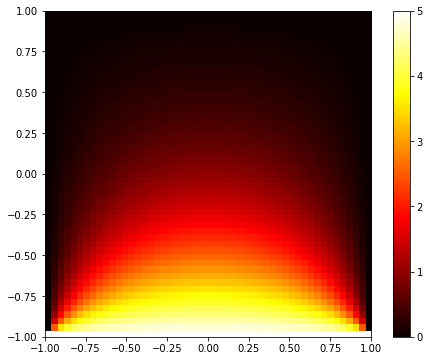

In [ ]:
# Execute the Forward Euler method for certain values of N and M to check the accuracy

N = 51
M = 10001
t_actual = 0.424011387033

u = np.zeros((N,N), dtype = np.float64)
u[-1,:] = np.float32(5)
u_n1 = np.copy(u)
dt = 1/(M-1)
dx = 2/(N-1)

C = (N-1)**2/(4*(M-1))
u_global_mem = cuda.to_device(u)
u_n1_global_mem = cuda.to_device(u_n1)

SX = 16
SY = 16
nblocks = int(np.ceil(N/SX))
        
t_star = 0
with Timer() as t:
  while u_global_mem[(N-1)//2,(N-1)//2] < 1.0:
    t_star += dt
    u_n1_global_mem = cuda.to_device(u_n1)
    forward_euler_gpu[(nblocks,nblocks), (SX,SY)](u_global_mem,u_n1_global_mem)
    u_global_mem = u_n1_global_mem

u = u_n1_global_mem.copy_to_host()

rel_err = abs(t_star-t_actual)/abs(t_actual)     
print(f"N: {N}, M: {M}, C: {C}")
print(f"t_star: {t_star}")
print(f"t_actual: {t_actual}")      
print(f"Relative error: {rel_err}")
print("Time cost: {0} s".format(t.interval))
print("\n")
plt.figure(figsize=(8,6))
plt.imshow(u, extent=(-1, 1, -1, 1), cmap='hot')
plt.colorbar()

### By increasing the number of discretisation points demonstrate how many correct digits you can achieve.

In order to research how the number of discretisation points $N$ and the number of time-steps $M$ influence the number of correct digits, I set a list of $C$ for every certain $N$ provided that when $C$ and $N$ is specified $M$ is a certain number with $C=\frac{\Delta t}{h^2}=\frac{(N-1)^2}{4(M-1)}.$ 

For the stability of the Forward Euler method, I set $C$ to be less than or equal to 0.25 as mentioned above.

In [ ]:
# set a list of N and C to research how the number of discretisation points N and time-steps M influence correct digits

t_actual = 0.424011387033
N_list = [11,101,201,301]
C_list = [0.25,0.125,0.0625,0.03125]

for N in N_list:

  print(f"N = {N}", end="\n")
  print(f"t_actual = {t_actual}")

  t_exe = 0
  table = PrettyTable(["C","M","t_star"],align = 'l')

  for C in C_list:

    @cuda.jit
    def forward_euler_gpu(u, u_n1):
      i, j = cuda.grid(2)
      if 0 < i < u.shape[0]-1 and 0 < j < u.shape[1]-1:
        u_n1[i,j] = u[i,j] - C*(4*u[i, j] - u[i-1,j] - u[i+1,j] - u[i,j-1] - u[i,j+1])

    table_data = []
    u = np.zeros((N,N), dtype = np.float64)
    u[0,:] = np.float32(5)
    u_n1 = np.copy(u)
    dx = 2/(N-1)
    dt = C*dx**2
    M = round(1/dt + 1)
    table_data.append(C)
    table_data.append(M)

    u_global_mem = cuda.to_device(u)
    u_n1_global_mem = cuda.to_device(u_n1)

    SX = 16
    SY = 16
    nblocks = int(np.ceil(N/SX))
        
    t_star = 0
    with Timer() as t:
        while u_global_mem[(N-1)//2,(N-1)//2] < 1.0:
          t_star += dt
          u_n1_global_mem = cuda.to_device(u_n1)
          forward_euler_gpu[(nblocks,nblocks), (SX,SY)](u_global_mem,u_n1_global_mem)
          u_global_mem = u_n1_global_mem
    t_exe += t.interval
      
    rel_err = abs(t_star-t_actual)/abs(t_actual)
    table_data.append(t_star)
    table.add_row(table_data)
    
  print(table)
  print(f"Time cost: {t_exe} s")
  print("\n")



N = 11
t_actual = 0.424011387033
+---------+-----+---------------------+
| C       | M   | t_star              |
+---------+-----+---------------------+
| 0.25    | 101 | 0.4200000000000003  |
| 0.125   | 201 | 0.4200000000000003  |
| 0.0625  | 401 | 0.4225000000000003  |
| 0.03125 | 801 | 0.42374999999999646 |
+---------+-----+---------------------+
Time cost: 1.2161285877227783 s


N = 101
t_actual = 0.424011387033
+---------+-------+---------------------+
| C       | M     | t_star              |
+---------+-------+---------------------+
| 0.25    | 10001 | 0.4239999999999696  |
| 0.125   | 20001 | 0.42399999999996146 |
| 0.0625  | 40001 | 0.4239999999999574  |
| 0.03125 | 80001 | 0.4240000000003417  |
+---------+-------+---------------------+
Time cost: 43.42120933532715 s


N = 201
t_actual = 0.424011387033
+---------+--------+---------------------+
| C       | M      | t_star              |
+---------+--------+---------------------+
| 0.25    | 40001  | 0.4239999999999574  |
| 0.

From the output, we can find when $C$ is certain, as the number of discretisation points $N$ increases, we get more correct digits. Here the most number of correct digits we get is $6$. Furthermore, when N is certain, the number of correct digits will grow as $C$ diceases namely the number of time steps increases. In conclusion, the number of correct digits is relevant to the discretisation points and time steps. When $C$ is certain, the smaller $\Delta t$ and $h$ is, the more correct digits we can get.

### Plot the convergence of the computed time  𝑡∗  against the actual time.

In order to observe a better convergence trend, I plot two graphs respectively against $N$ and $M$. With the same aim, for either of the two graphs, I set the other factor than the x-axis to be a certain value. 

For the convergence plot against $N$, when $M$ is specified as $100001$ the maximum value of $N$ is about $317$ according to the stability condition  $C=\frac{\Delta t}{h^2} \lesssim \frac{1}{4}.$ 

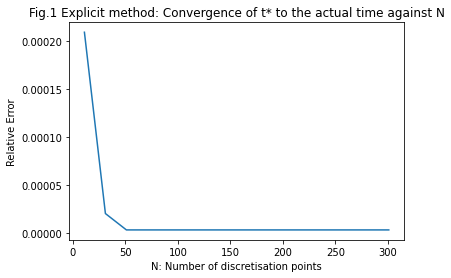

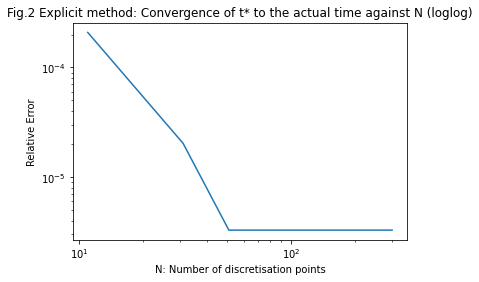

In [ ]:
# Plot the convergence graph against the number of discretisation points for a certain number of time steps

M = 100001
N_list = [11,31,51,71,91,101,201,301]
err_list = []

for N in N_list: 

  @cuda.jit
  def forward_euler_gpu(u, u_n1):
    i, j = cuda.grid(2)
    if 0 < i < u.shape[0]-1 and 0 < j < u.shape[1]-1:
          u_n1[i,j] = u[i,j] - C*(4*u[i, j] - u[i-1,j] - u[i+1,j] - u[i,j-1] - u[i,j+1])

  u = np.zeros((N,N), dtype = np.float64)
  u[0,:] = np.float32(5)
  u_n1 = np.copy(u)
  dx = 2/(N-1)
  dt = 1/(M-1)
  C = dt/dx**2

  u_global_mem = cuda.to_device(u)
  u_n1_global_mem = cuda.to_device(u_n1)

  SX = 16
  SY = 16
  nblocks = int(np.ceil(N/SX))
        
  t_star = 0

  while u_global_mem[(N-1)//2,(N-1)//2] < 1.0:
    t_star += dt
    u_n1_global_mem = cuda.to_device(u_n1)
    forward_euler_gpu[(nblocks,nblocks), (SX,SY)](u_global_mem,u_n1_global_mem)
    u_global_mem = u_n1_global_mem
  
  t_exe += t.interval

  rel_err = abs(t_star-t_actual)/abs(t_actual)
  err_list.append(rel_err)


plt.plot(N_list, err_list)
plt.xlabel("N: Number of discretisation points")
plt.ylabel("Relative Error")
plt.title("Fig.1 Explicit method: Convergence of t* to the actual time against N")
plt.show()

plt.loglog(N_list, err_list)
plt.xlabel("N: Number of discretisation points")
plt.ylabel("Relative Error")
plt.title("Fig.2 Explicit method: Convergence of t* to the actual time against N (loglog)")
plt.show()

From the plot, we can see that the convergence of $t*$ is quadratic. When time steps are certain, more discretisation points will lead to a smaller relative error and a $t*$ closer to the actual $t$.

For the convergence plot against $M$, when $N$ is specified as $51$ the minimum value of $M$ is about $2501$ according to $C=\frac{\Delta t}{h^2} \lesssim \frac{1}{4}.$ 

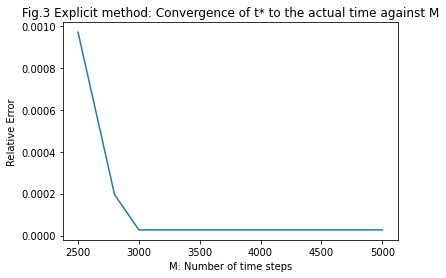

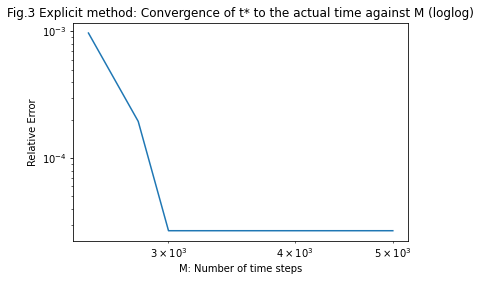

In [ ]:
# Plot the convergence graph against the number of time steps for a certain number of discretisation points

N = 51
M_list = [2501,2801,3001,3501,5001]
err_list = []

for M in M_list: 

  @cuda.jit
  def forward_euler_gpu(u, u_n1):
    i, j = cuda.grid(2)
    if 0 < i < u.shape[0]-1 and 0 < j < u.shape[1]-1:
          u_n1[i,j] = u[i,j] - C*(4*u[i, j] - u[i-1,j] - u[i+1,j] - u[i,j-1] - u[i,j+1])

  u = np.zeros((N,N), dtype = np.float64)
  u[0,:] = np.float32(5)
  u_n1 = np.copy(u)
  dx = 2/(N-1)
  dt = 1/(M-1)
  C = dt/dx**2

  u_global_mem = cuda.to_device(u)
  u_n1_global_mem = cuda.to_device(u_n1)

  SX = 16
  SY = 16
  nblocks = int(np.ceil(N/SX))
        
  t_star = 0
  while u_global_mem[(N-1)//2,(N-1)//2] < 1.0:
    t_star += dt
    u_n1_global_mem = cuda.to_device(u_n1)
    forward_euler_gpu[(nblocks,nblocks), (SX,SY)](u_global_mem,u_n1_global_mem)
    u_global_mem = u_n1_global_mem
  
  rel_err = abs(t_star-t_actual)/abs(t_actual)
  err_list.append(rel_err)

plt.plot(M_list, err_list)
plt.xlabel("M: Number of time steps")
plt.ylabel("Relative Error")
plt.title("Fig.3 Explicit method: Convergence of t* to the actual time against M")
plt.show()

plt.loglog(M_list, err_list)
plt.xlabel("M: Number of time steps")
plt.ylabel("Relative Error")
plt.title("Fig.3 Explicit method: Convergence of t* to the actual time against M (loglog)")
plt.show()


From the graph of convergence of $t*$ against the number of time steps, we find when discretisation points is certain, we will get a more precise $t*$ with more time steps.

## Implicit method: Backward Euler

### Implement a finite difference scheme with the explicit time-stepping supported by the Backward Euler method.

For the implicit time stepping I will use the Backward Euler method which gives
$u_{n+1} = u_n + \Delta t \Delta u_{n+1}$.

To solve this problem, we have to solve a linear equation. For simplifying the algorithm, treat $\Delta u_{n+1} = Au_{n+1}$ where the matrix $A$ is the Laplace operator derived from 5 stencil. Then we get $u_{n+1} = (I-\Delta tA)^{-1} u_{n}.$


Here, I will use the discretise_poisson function on the lecture notes to generate $A$. To fit the case, I've modified the function by setting $h = \frac {2}{N-1}$ and handling the sign of minus.


In [ ]:
def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    h = 2/(N-1)
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = -4 / h**2
                data[count + 1 : count + 5] = 1 / h**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

In [ ]:
# Define a function to execute the Backward Euler method

def backward_euler(u, dt):
    u_n = u.reshape((N*N))
    u_n1 = spsolve((I-dt*A),u_n)
    u_n1 = u_n1.reshape((N,N))
    u_n1[-1,:] = 5
    
    return u_n1


N: 51, M: 10001, C: 0.0625
t_star: 0.4240999999999696
t_actual: 0.424011387033
Relative error: 0.00020898723402139866
Time cost: 39.50638008117676 s




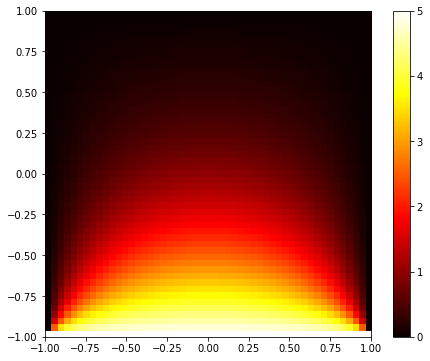

In [ ]:
# Execute the Backward Euler method for certain values for N and time_steps M to check the accuracy

N = 51
M = 10001
t_actual = 0.424011387033

A,_ = discretise_poisson(N)
I = identity(N*N)

u = np.zeros((N,N), dtype = np.float64)
u[-1,:] = np.float32(5)
dx = 2/(N-1)
C = (N-1)**2/(4*(M-1))
dt = C*dx**2

t_star = 0
with Timer() as t:
  while u[N//2,N//2] < 1:
      u = backward_euler(u,dt)
      t_star += dt

rel_err = abs(t_star-t_actual)/abs(t_actual)     
print(f"N: {N}, M: {M}, C: {C}")
print(f"t_star: {t_star}")
print(f"t_actual: {t_actual}")      
print(f"Relative error: {rel_err}")
print("Time cost: {0} s".format(t.interval))
print("\n")
plt.figure(figsize=(8,6))
plt.imshow(u, extent=(-1, 1, -1, 1), cmap='hot')
plt.colorbar()

### By increasing the number of discretisation points demonstrate how many correct digits you can achieve.

For the Backward Euler method, there is no conditon for $C$ but the execution time increases without the help pf GPU. Therefore, I choose smaller $N$ and larger $C$ to compute $t*.$

In [ ]:
# set a list of N and C to research how the number of discretisation points N and time-steps M influence correct digits

t_actual = 0.424011387033
N_list = [11,51,81,101]
C_list = [1,0.5,0.25,0.125]

for N in N_list:

  print(f"N = {N}", end="\n")
  print(f"t_actual = {t_actual}")

  t_exe = 0
  table = PrettyTable(["C","M","t_star"],align = 'l')
  

  for C in C_list:
    table_data = []
    
    A,_ = discretise_poisson(N)
    I = identity(N*N)

    u = np.zeros((N,N), dtype = np.float64)
    u[-1,:] = np.float32(5)

    dx = 2/(N-1)
    dt = C*dx**2
    M = round(1/dt + 1)
    table_data.append(C)
    table_data.append(M)
    
    t_star = 0
    with Timer() as t:
      while u[N//2,N//2] < 1:
          u = backward_euler(u,dt)
          t_star += dt

    t_exe += t.interval

    rel_err = abs(t_star-t_actual)/abs(t_actual)
    table_data.append(t_star)
    table.add_row(table_data)
    
  print(table)
  print(f"Time cost: {t_exe} s")
  print("\n")


N = 11
t_actual = 0.424011387033
+-------+-----+---------------------+
| C     | M   | t_star              |
+-------+-----+---------------------+
| 1     | 26  | 0.44000000000000017 |
| 0.5   | 51  | 0.4400000000000003  |
| 0.25  | 101 | 0.4300000000000003  |
| 0.125 | 201 | 0.4300000000000003  |
+-------+-----+---------------------+
Time cost: 0.0996863842010498 s


N = 51
t_actual = 0.424011387033
+-------+------+---------------------+
| C     | M    | t_star              |
+-------+------+---------------------+
| 1     | 626  | 0.4255999999999983  |
| 0.5   | 1251 | 0.42480000000000395 |
| 0.25  | 2501 | 0.42440000000000805 |
| 0.125 | 5001 | 0.4241999999999859  |
+-------+------+---------------------+
Time cost: 27.694674253463745 s


N = 81
t_actual = 0.424011387033
+-------+-------+---------------------+
| C     | M     | t_star              |
+-------+-------+---------------------+
| 1     | 1601  | 0.42437499999999373 |
| 0.5   | 3201  | 0.42437499999999234 |
| 0.25  | 6401  |

Similar with the conclusion for the Forward Euler method, when $C$ is certain,   the larger $N$ and $M$ is or the smaller $\Delta t$ and $h$ is, the more correct digits we can get.

### Plot the convergence of the computed time  𝑡∗  against the actual time.

I will use the same scheme as that for the Forward Euler method to plot in order to evaluate how the time steps and discretisation points influence $t*.$ Also, to save execution time, I have to choose smaller M and N.

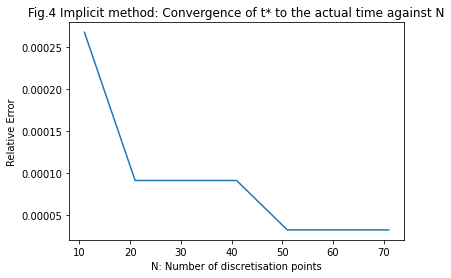

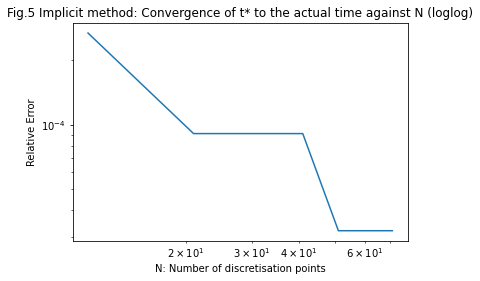

In [19]:
# Plot the convergence graph against the number of discretisation points for a certain number of time steps

M = 40001
N_list = [11,21,31,41,51,71]
err_list = []

for N in N_list: 
    
  A,_ = discretise_poisson(N)
  I = identity(N*N)

  u = np.zeros((N,N), dtype = np.float64)
  u[-1,:] = np.float32(5)

  dx = 2/(N-1)
  dt = 1/(M-1)
  C = dt/dx**2
    
  t_star = 0
  while u[N//2,N//2] < 1:
    u = backward_euler(u,dt)
    t_star += dt
  
  rel_err = abs(t_star-t_actual)/abs(t_actual)
  err_list.append(rel_err)

 
plt.plot(N_list, err_list)
plt.xlabel("N: Number of discretisation points")
plt.ylabel("Relative Error")
plt.title("Fig.4 Implicit method: Convergence of t* to the actual time against N")
plt.show()
  
plt.loglog(N_list, err_list)
plt.xlabel("N: Number of discretisation points")
plt.ylabel("Relative Error")
plt.title("Fig.5 Implicit method: Convergence of t* to the actual time against N (loglog)")
plt.show()

It is obvious that when time steps are certain, $t*$ converges quadratically to $t$ as discretisation points increase. 

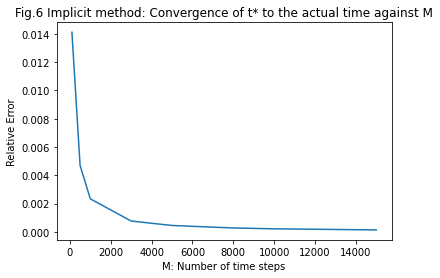

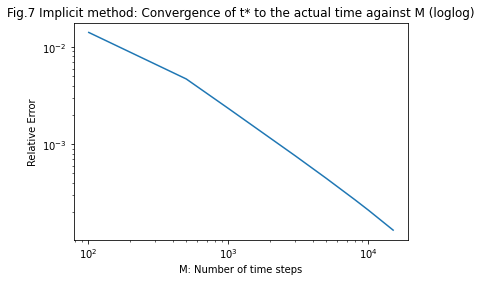

In [ ]:
# Plot the convergence graph against the number of time steps for a certain number of discretisation points

N = 101
M_list = [101,501,1001,3001,5001,8001,10001,15001]
err_list = []

for M in M_list: 
    
  A,_ = discretise_poisson(N)
  I = identity(N*N)

  u = np.zeros((N,N), dtype = np.float64)
  u[-1,:] = np.float32(5)

  dx = 2/(N-1)
  dt = 1/(M-1)
  C = dt/dx**2
    
  t_star = 0
  while u[N//2,N//2] < 1:
    u = backward_euler(u,dt)
    t_star += dt
  
  rel_err = abs(t_star-t_actual)/abs(t_actual)
  err_list.append(rel_err)

plt.plot(M_list, err_list)
plt.xlabel("M: Number of time steps")
plt.ylabel("Relative Error")
plt.title("Fig.6 Implicit method: Convergence of t* to the actual time against M")
plt.show()

plt.loglog(M_list, err_list)
plt.xlabel("M: Number of time steps")
plt.ylabel("Relative Error")
plt.title("Fig.7 Implicit method: Convergence of t* to the actual time against M (loglog)")
plt.show()


Also, when $N$ is certain, as $M$ increases $t*$ quadratically converges to the actual $t$, which is similar to the Forward Euler mathod.